<a href="https://colab.research.google.com/github/BenaJovi/CSCI_164_Project/blob/main/164_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor


# Movie data

In [ ]:
# Replace with your actual file ID
file_id = "1KABsIvTGI6KtWr98gUqFDyWninMhLhvS"
url = f"https://drive.google.com/uc?id={file_id}"
movie_df = pd.read_csv(url)

movie_df = movie_df.dropna(subset=[
    'imdb_score', 'duration', 'budget', 'gross',
    'num_critic_for_reviews', 'cast_total_facebook_likes',
    'director_facebook_likes', 'content_rating', 'genres'
])
movie_df.head()


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,1.221550e+10,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,4.200000e+09,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,2.500000e+09,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,2.400000e+09,2012.0,23000.0,8.5,2.35,164000
5,Color,Andrew Stanton,462.0,132.0,475.0,530.0,Samantha Morton,640.0,73058679.0,Action|Adventure|Sci-Fi,...,738.0,English,USA,PG-13,1.100000e+09,2012.0,632.0,6.6,2.35,24000


Applying log transformation to the budget and the gross columns to reduce skewness. Then we select a set of numeric and categrotical featrues we beleive to be predictive of IMDb scores.

In [ ]:
# Log transform budget and gross to reduce skew
movie_df['log_budget'] = np.log1p(movie_df['budget'])
movie_df['log_gross'] = np.log1p(movie_df['gross'])

# Select features and target
features = [
    'duration', 'log_budget', 'log_gross',
    'num_critic_for_reviews', 'cast_total_facebook_likes',
    'director_facebook_likes', 'content_rating'
]
target = 'imdb_score'

X = movie_df[features]
y = movie_df[target]



Exploring the Data: visually seeing the data to understand the distribution of scores and the relationship betweren selected features and the IMDb score.

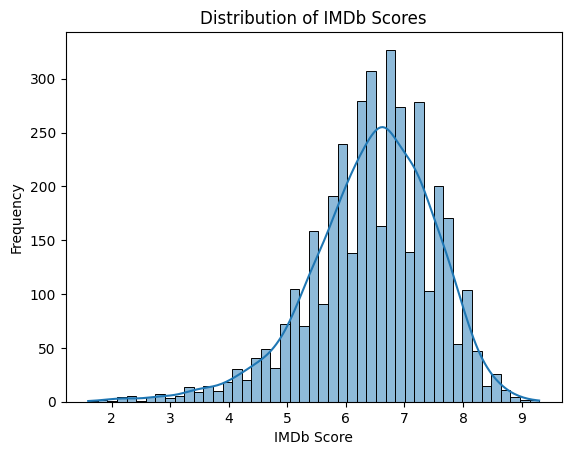

In [ ]:
#  Step 3.5: Exploratory Data Analysis (EDA)

# Distribution of IMDb Scores
sns.histplot(movie_df['imdb_score'], kde=True)
plt.title("Distribution of IMDb Scores")
plt.xlabel("IMDb Score")
plt.ylabel("Frequency")
plt.show()


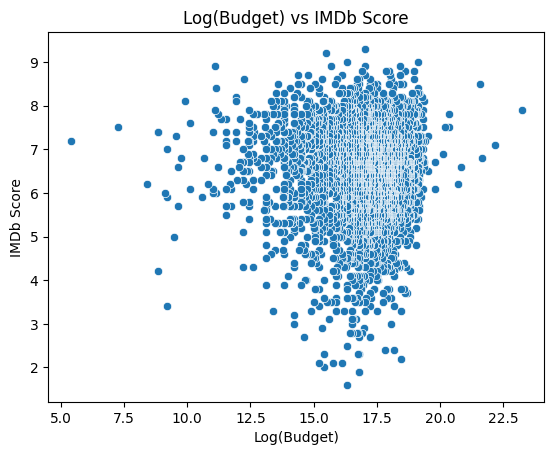

In [ ]:
# Log(Budget) vs IMDb Score
sns.scatterplot(x='log_budget', y='imdb_score', data=movie_df)
plt.title("Log(Budget) vs IMDb Score")
plt.xlabel("Log(Budget)")
plt.ylabel("IMDb Score")
plt.show()


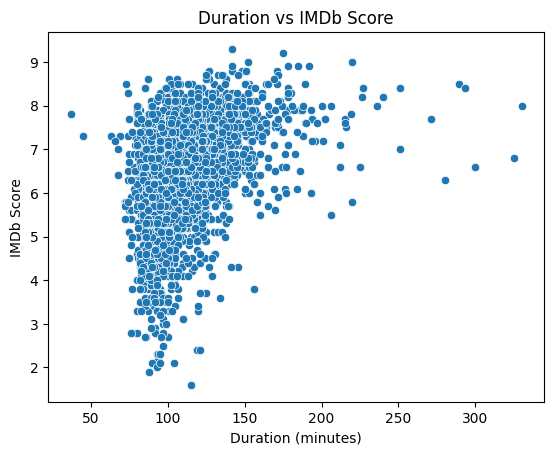

In [ ]:
# Duration vs IMDb Score
sns.scatterplot(x='duration', y='imdb_score', data=movie_df)
plt.title("Duration vs IMDb Score")
plt.xlabel("Duration (minutes)")
plt.ylabel("IMDb Score")
plt.show()


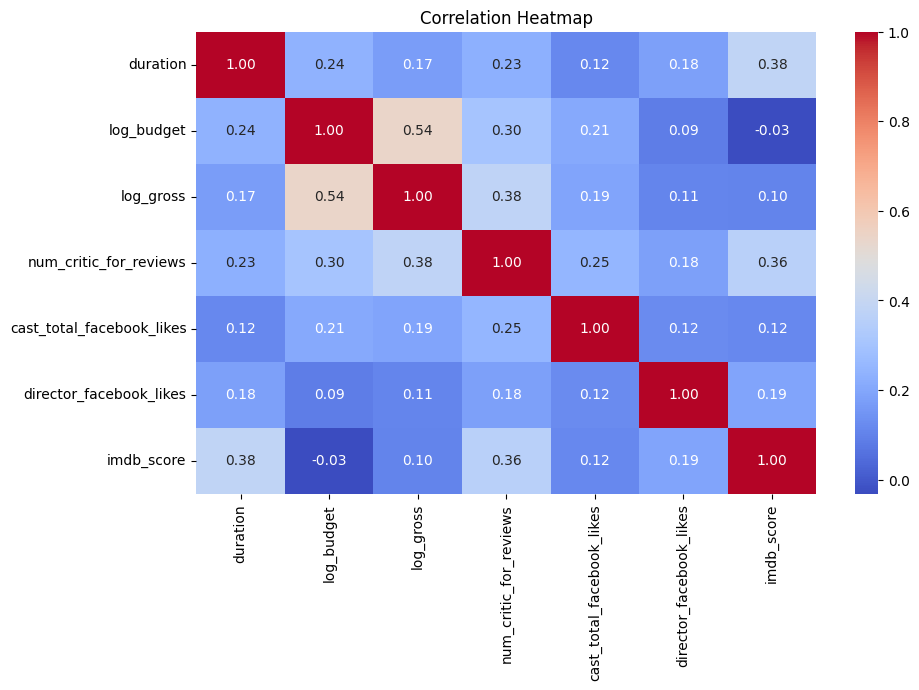

In [ ]:
# Correlation Heatmap (numeric only)
corr_features = [
    'duration', 'log_budget', 'log_gross',
    'num_critic_for_reviews', 'cast_total_facebook_likes',
    'director_facebook_likes', 'imdb_score'
]

corr_matrix = movie_df[corr_features].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


We usue column transfer to standardize the numeric features and apply one-hot encoding to the categorical feature. This ensures our model receives properly scaled numerical values and binary representatinos of categorical inputs.

In [ ]:
numeric_features = [
    'duration', 'log_budget', 'log_gross',
    'num_critic_for_reviews', 'cast_total_facebook_likes',
    'director_facebook_likes'
]
categorical_features = ['content_rating']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


splinting the data into training and testing subsets using an 80/20 split. This allows us to evaluate model performace on unseen data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


The 3 models we are using. Each is wrapped in a pipeline that includes preprocessing.

In [ ]:
from sklearn.linear_model import LinearRegression

# Step 6: Model Pipelines
lin_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

mlp_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000))
])



In [ ]:
ridge_pipe.fit(X_train, y_train)
lin_pipe.fit(X_train, y_train)
mlp_pipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['duration', 'log_budget',
                                                   'log_gross',
                                                   'num_critic_for_reviews',
                                                   'cast_total_facebook_likes',
                                                   'director_facebook_likes']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['content_rating'])])),
                ('regressor', MLPRegressor(max_iter=1000))])

Evaluating the models useing MSE and R squared score to determine how well each model predicts IMDb scores on the test set.

In [ ]:
models = [("Linear", lin_pipe), ("Ridge", ridge_pipe), ("MLP", mlp_pipe)]

for name, model in models:
    preds = model.predict(X_test)
    print(f"{name} Model")
    print("MSE:", mean_squared_error(y_test, preds))
    print("R²:", r2_score(y_test, preds), "\n")


Linear Model
MSE: 0.8382346081212896
R²: 0.27944210784240875 

Ridge Model
MSE: 0.8380790524587364
R²: 0.27957582560976946 

MLP Model
MSE: 0.770272880955474
R²: 0.3378629346605059 



Visuals: Predicted vs actual IMDb scores to assess how closely the model ouptuts align with the actual scores. A perfect prediction would be on the red line.

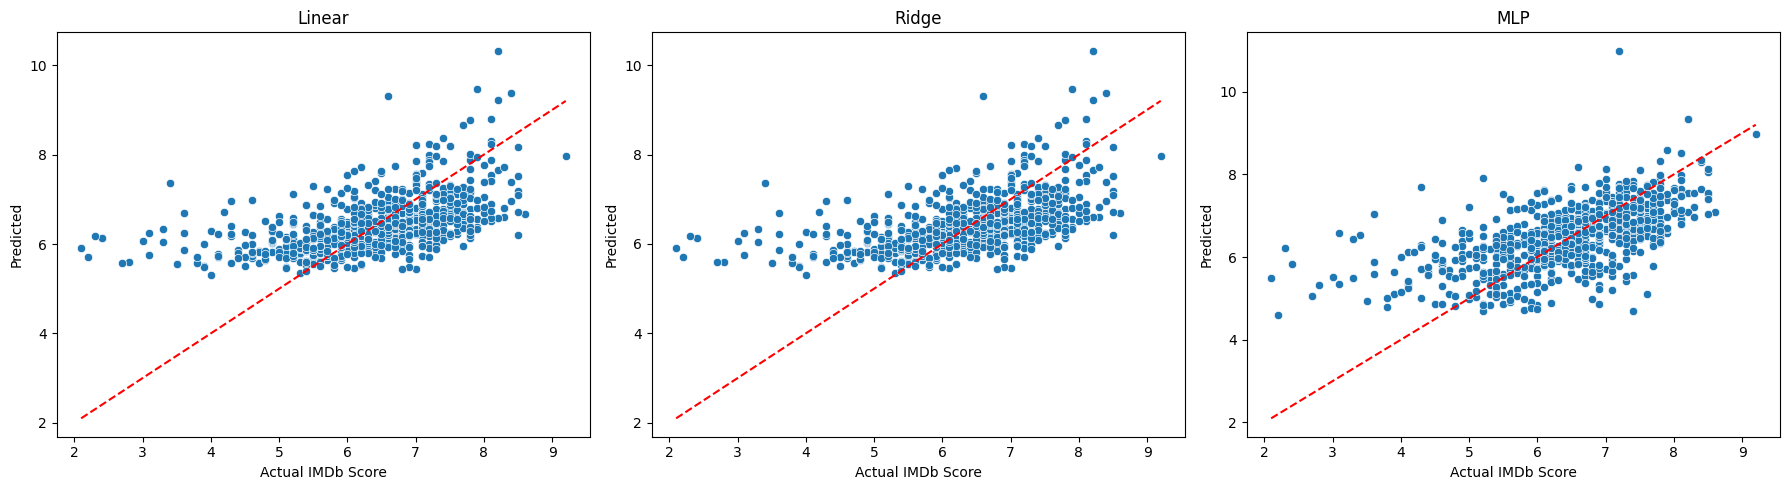

In [ ]:
plt.figure(figsize=(18, 5))

for idx, (name, model) in enumerate(models, 1):
    preds = model.predict(X_test)
    plt.subplot(1, 3, idx)
    sns.scatterplot(x=y_test, y=preds)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual IMDb Score")
    plt.ylabel("Predicted")
    plt.title(name)

plt.tight_layout()
plt.show()


5-fold cross validation on all models to evalue their generalizability.

In [ ]:
for name, model in models:
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"{name} Cross-Validated R²: Mean = {scores.mean():.4f}, Std = {scores.std():.4f}")


Linear Cross-Validated R²: Mean = 0.2504, Std = 0.1125
Ridge Cross-Validated R²: Mean = 0.2554, Std = 0.1027
MLP Cross-Validated R²: Mean = 0.3313, Std = 0.1379


We now fine tune the ridge and MLP using GridSearchCV

In [ ]:
# GridSearchCV for Ridge Regression
from sklearn.model_selection import GridSearchCV

ridge_param_grid = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

ridge_search = GridSearchCV(ridge_pipe, ridge_param_grid, cv=5, scoring='r2', verbose=1)
ridge_search.fit(X_train, y_train)

print("Best Ridge Parameters:", ridge_search.best_params_)
print("Best Ridge Cross-Validated R²:", ridge_search.best_score_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Ridge Parameters: {'regressor__alpha': 10.0}
Best Ridge Cross-Validated R²: 0.29523025705176603


In [ ]:
# GridSearchCV for MLP Regressor
mlp_param_grid = {
    'regressor__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'regressor__alpha': [0.0001, 0.001, 0.01],
    'regressor__learning_rate_init': [0.001, 0.01],
    'regressor__max_iter': [1000]
}

mlp_search = GridSearchCV(mlp_pipe, mlp_param_grid, cv=5, scoring='r2', verbose=1)
mlp_search.fit(X_train, y_train)

print("Best MLP Parameters:", mlp_search.best_params_)
print("Best MLP Cross-Validated R²:", mlp_search.best_score_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best MLP Parameters: {'regressor__alpha': 0.01, 'regressor__hidden_layer_sizes': (100,), 'regressor__learning_rate_init': 0.001, 'regressor__max_iter': 1000}
Best MLP Cross-Validated R²: 0.38412178519312234


how the tuned model perform using the data set

In [ ]:
# Evaluate best estimators on test set
tuned_models = [("Ridge (Tuned)", ridge_search.best_estimator_),
                ("MLP (Tuned)", mlp_search.best_estimator_)]

for name, model in tuned_models:
    preds = model.predict(X_test)
    print(f"{name}")
    print("MSE:", mean_squared_error(y_test, preds))
    print("R²:", r2_score(y_test, preds), "\n")


Ridge (Tuned)
MSE: 0.8373703796249512
R²: 0.2801850104351087 

MLP (Tuned)
MSE: 0.7533884762568905
R²: 0.35237699903111774 



Final visual of comparing the predictions from the tuned Riidge and MLP models

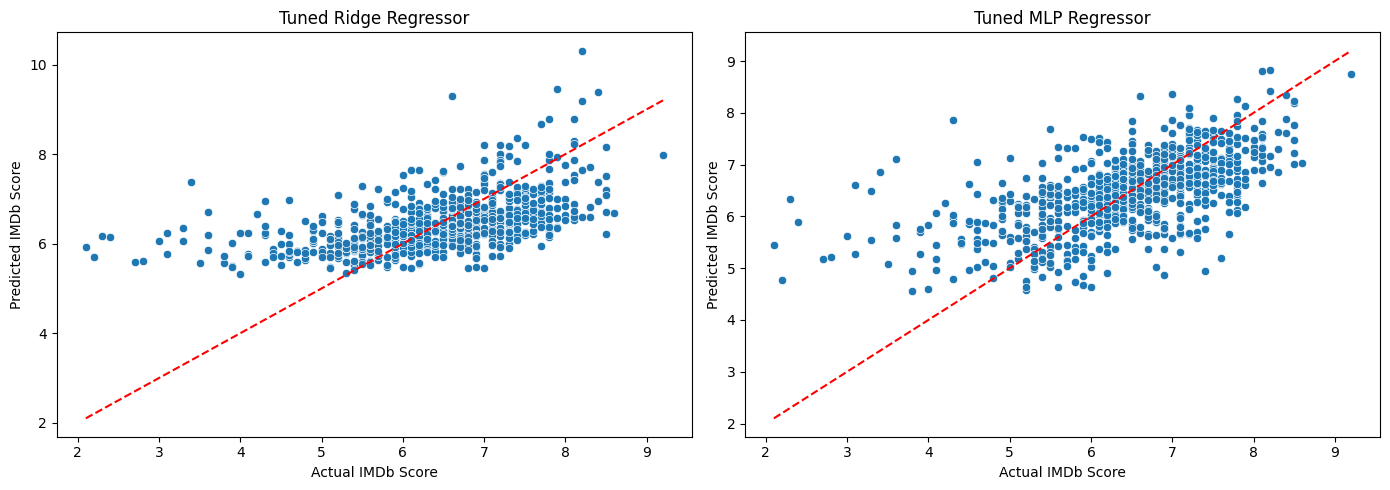

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions from tuned models
ridge_tuned_preds = ridge_search.best_estimator_.predict(X_test)
mlp_tuned_preds = mlp_search.best_estimator_.predict(X_test)

# Set up side-by-side plots
plt.figure(figsize=(14, 5))

# Ridge
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=ridge_tuned_preds)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual IMDb Score")
plt.ylabel("Predicted IMDb Score")
plt.title("Tuned Ridge Regressor")

# MLP
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=mlp_tuned_preds)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual IMDb Score")
plt.ylabel("Predicted IMDb Score")
plt.title("Tuned MLP Regressor")

plt.tight_layout()
plt.show()


# Car Data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# prompt: import csv file directly from google drive with the link: https://drive.google.com/file/d/1ZVxPnFtgbCo-2Szv6BXHEXBGmb1e99DC/view?usp=sharing
import numpy as np

# Replace with your actual file ID
file_id = '1ZVxPnFtgbCo-2Szv6BXHEXBGmb1e99DC'
url = f'https://drive.google.com/uc?id={file_id}'

df = pd.read_csv(url)


Separate the features in groups of numerical and categorical. Find prediction variable.

In [ ]:
# Separate features and target variable
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

# Identify categorical and numerical features
categorical_features = ['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission']
numerical_features = ['Year', 'Present_Price', 'Kms_Driven', 'Owner']

Numerical features are standardized using Standard Scaler and the categorical features are encoded into numerical features using onehot encoding. Onehot encoding is used because it creates independent features, handles multi-category features effectively, and avoids ordinality.

In [ ]:
# Preprocessing pipelines
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first') # Drop one category to avoid multicollinearity

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drop other columns not specified in transformers
)

Split the training data and the test data. The training data is given 80% of the data to ensure accurate predictions.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


For the 1st model, linear regression was an interpretable baseline model and for understanding potential linear relationships. However, due to the likely presence of non-linearities and interactions, more sophisticated models are generally expected to achieve higher predictive accuracy.

In [ ]:
# --- Model 1: Linear Regression ---
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', LinearRegression())])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression - MSE: {mse_lr:.2f}, R-squared: {r2_lr:.2f}")

Linear Regression - MSE: 9.23, R-squared: 0.60


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Random forest regressor is a good model for Car_data because the used car market is influenced by a multitude of factors that interact in non-linear ways (e.g., age, mileage, brand reputation, fuel efficiency, seller type). Random Forests are well-suited to model these intricate relationships. However, it is less interpretable than the linear regressor, and more computationally expensive.

In [ ]:
# --- Model 2: Random Forest Regressor ---
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor(random_state=42))])
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest Regressor - MSE: {mse_rf:.2f}, R-squared: {r2_rf:.2f}")

Random Forest Regressor - MSE: 0.77, R-squared: 0.97


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


KNN Regressor a non-parametric algorithm, meaning it doesn't make strong assumptions about the underlying functional form of the data. This flexibility allows it to capture complex, non-linear relationships between the features. It is also intuitive and easy to understand. However, the model is sensitive to feature scaling and onehot encoding can cause nearest neighbors to matter less. Also, assuming similarity means similar price: this can be untrue, an example would be if an individual sold a car versus a dealer, the dealer would charge more for the same car.

In [ ]:
# --- Model 3: K-Nearest Neighbors Regressor ---
pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', KNeighborsRegressor())])
pipeline_knn.fit(X_train, y_train)
y_pred_knn = pipeline_knn.predict(X_test)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print(f"K-Nearest Neighbors Regressor - MSE: {mse_knn:.2f}, R-squared: {r2_knn:.2f}")

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


K-Nearest Neighbors Regressor - MSE: 1.28, R-squared: 0.94


Linear Regression does not benefit from hyperparameter tuning and is therefore skipped. The best hyperparameters are chosen from the parameter grid given. 5 folds are given for the cross-validation. After the best hyperparameters are chosen, that model is tested to find the MSE and R-squared values.

In [ ]:
from sklearn.model_selection import GridSearchCV

# --- Hyperparameter Tuning for Random Forest ---
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 3, 5]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
best_mse_rf = mean_squared_error(y_test, y_pred_best_rf)
best_r2_rf = r2_score(y_test, y_pred_best_rf)
print(f"\nBest Random Forest - MSE: {best_mse_rf:.2f}, R-squared: {best_r2_rf:.2f}")
print(f"Best Random Forest Hyperparameters: {grid_search_rf.best_params_}")


Best Random Forest - MSE: 0.75, R-squared: 0.97
Best Random Forest Hyperparameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Similar to the previous, the best hyperparamters are found using a parameter grid and then tested to find the MSE and R-squared values. This model also has 5 fold cross-validation.

In [ ]:
# --- Hyperparameter Tuning for K-Nearest Neighbors ---
param_grid_knn = {
    'regressor__n_neighbors': [3, 5, 7, 9, 11],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__p': [1, 2] # 1 for Manhattan distance, 2 for Euclidean distance
}

grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

best_knn_model = grid_search_knn.best_estimator_
y_pred_best_knn = best_knn_model.predict(X_test)
best_mse_knn = mean_squared_error(y_test, y_pred_best_knn)
best_r2_knn = r2_score(y_test, y_pred_best_knn) # Use y_pred_best_knn instead of best_r2_knn
print(f"\nBest K-Nearest Neighbors - MSE: {best_mse_knn:.2f}, R-squared: {best_r2_knn:.2f}")
print(f"Best KNN Hyperparameters: {grid_search_knn.best_params_}")


Best K-Nearest Neighbors - MSE: 1.09, R-squared: 0.95
Best KNN Hyperparameters: {'regressor__n_neighbors': 3, 'regressor__p': 2, 'regressor__weights': 'distance'}


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


As we can see below, the best performing model is best randomized forest. With the smallest MSE and an R-squared value of nearly 1, it outperforms KNN regressor slightly and completely beats linear regression.

In [ ]:
# Linear Regression typically doesn't benefit much from extensive hyperparameter tuning
# with GridSearchCV on the coefficients themselves. Feature engineering or regularization
# (L1, L2) would be more relevant, but for simplicity in this demonstration, we'll skip
# detailed tuning for Linear Regression.

print("\n--- Model Comparison ---")
print(f"Linear Regression - MSE: {mse_lr:.2f}, R-squared: {r2_lr:.2f}")
print(f"Best Random Forest - MSE: {best_mse_rf:.2f}, R-squared: {best_r2_rf:.2f}")
print(f"Best K-Nearest Neighbors - MSE: {best_mse_knn:.2f}, R-squared: {best_r2_knn:.2f}")


--- Model Comparison ---
Linear Regression - MSE: 9.23, R-squared: 0.60
Best Random Forest - MSE: 0.75, R-squared: 0.97
Best K-Nearest Neighbors - MSE: 1.09, R-squared: 0.95


Below is the visualised plot that depicts the MSE and R-squared values. MSE is shown by the distance from the line each dot is, and the R-squared value is how close the dots resemble the straight line.

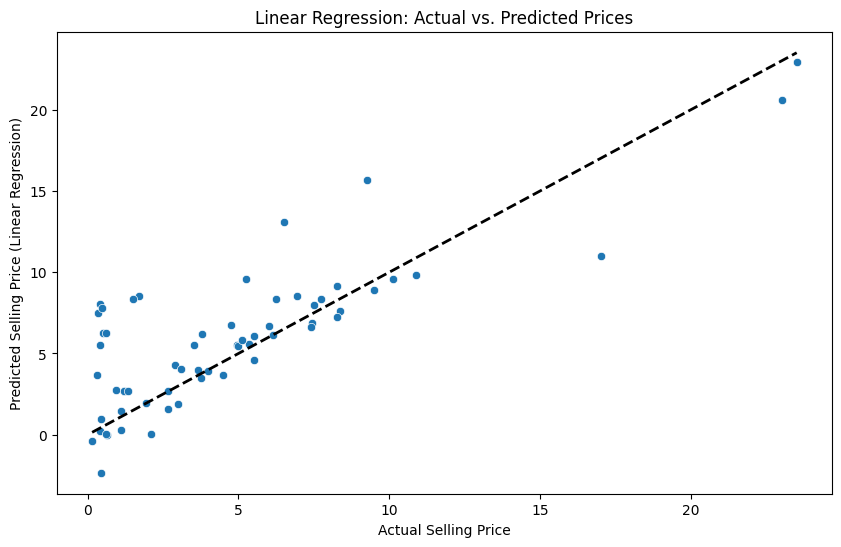

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# For regression tasks, we'll focus on scatter plots of predictions vs. actual values

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_lr)
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price (Linear Regression)")
plt.title("Linear Regression: Actual vs. Predicted Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line for perfect predictions
plt.show()

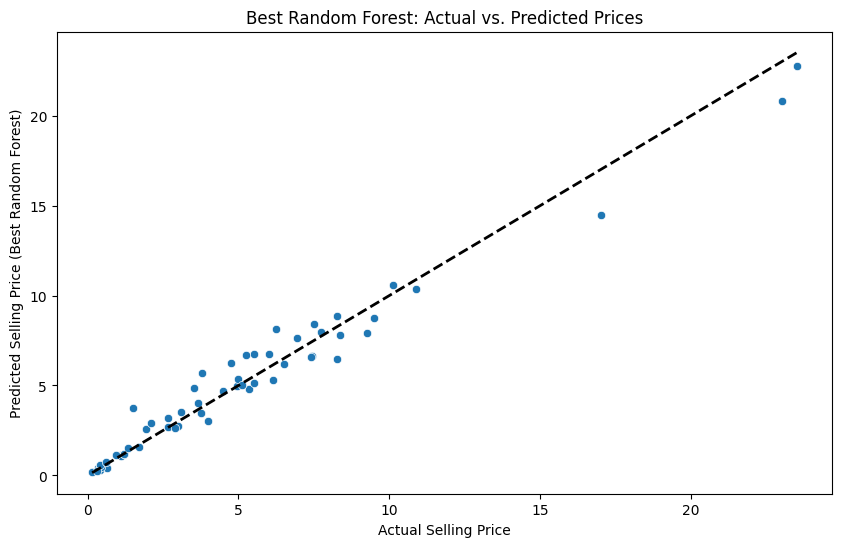

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best_rf)
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price (Best Random Forest)")
plt.title("Best Random Forest: Actual vs. Predicted Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()


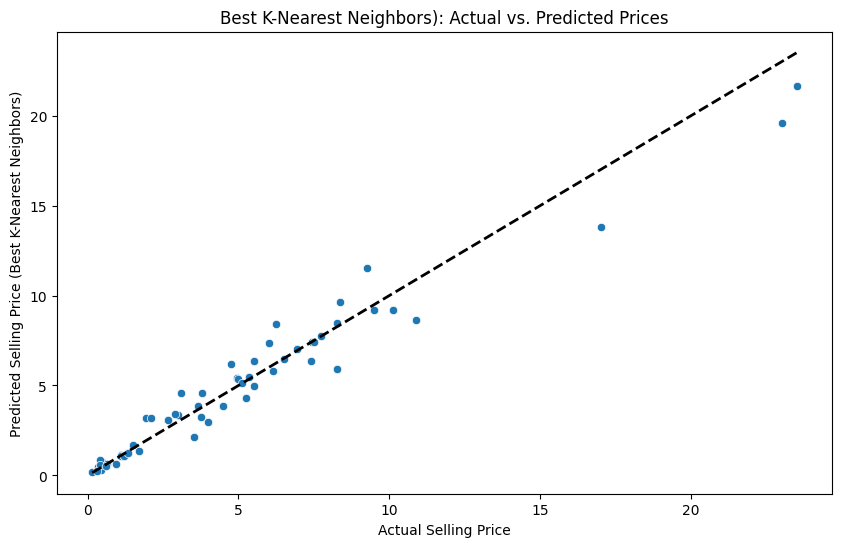

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best_knn)
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price (Best K-Nearest Neighbors)")
plt.title("Best K-Nearest Neighbors): Actual vs. Predicted Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()